In [ ]:
# default_exp funcs.train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2

# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
#export
def eval_logger(pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,matches,shift = matching(target_df, pred_df, print_res=False,  match_genes=True)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False,  match_genes=True)

    wandb.log({data_str +'Metrics/eff_3d': perf_dict['eff_3d']}, step=iteration)
    wandb.log({data_str +'Metrics/jaccard': perf_dict['jaccard']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_vol': perf_dict['rmse_vol']}, step=iteration)

    wandb.log({data_str +'Metrics/precision': perf_dict['precision']}, step=iteration)
    wandb.log({data_str +'Metrics/recall': perf_dict['recall']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_x': perf_dict['rmse_x']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_y': perf_dict['rmse_y']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_z': perf_dict['rmse_z']}, step=iteration)   
    
    return matches
    
def load_from_eval_dict(eval_dict):
    
    eval_img = load_tiff_image(sorted(glob.glob(eval_dict['image_path']))[eval_dict['img_ind']])#[eval_dict['sm_fish_ch']][None]
    eval_img = eval_img[eval_dict['crop_sl']]
    eval_df = None
    eval_psf = None
    if eval_dict['txt_path'] is not None:
        txt_path = sorted(glob.glob(eval_dict['txt_path']))[eval_dict['img_ind']]
        eval_df = simfish_to_df(txt_path)
        eval_df = crop_df(eval_df, eval_dict['crop_sl'], px_size_zyx=eval_dict['px_size_zyx'])

    if eval_dict['psf_path'] is not None:
        eval_psf = load_tiff_image(eval_dict['psf_path'])
        
    return eval_img, eval_df, eval_psf

def save_train_state(save_dir, model, microscope, optim_dict, train_iter):
    
        torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/'model.pkl')
        torch.save(microscope.state_dict(), save_dir/'microscope.pkl')
        
        save_dict = {k:v.state_dict() for (k,v) in optim_dict.items()}
        save_dict['train_iter'] = train_iter
        
        torch.save(save_dict, save_dir/'training_state.pkl')

In [ ]:
#export
def train(cfg,
          model, 
          microscope,
          post_proc,
          dl, 
          optim_dict,
          eval_dict=None):
    
    """
    Training loop for autoencoder learning. Alternates between a simulator training step to train the inference network
    and an autoencoder step to train the PSF (and microscope) parameters.
    
    Args:
        model (torch.nn.Module): DECODE 3D UNet.
        dl  (torch.utils.data.dataloader.DataLoader): Dataloader that returns a random sub volume from the real volume, an estiamted emitter density and background.
        optim_net  (torch.optim.Optimizer): Optimizer for the network parameters.
        optim_mic  (torch.optim.Optimizer): Optimizer for the PSF parameters.
        sched_net  (torch.optim.lr_scheduler): LR scheduler for the network parameters.
        sched_mic  (torch.optim.lr_scheduler): LR scheduler for the PSF parameters.
        microscope (torch.nn.Module): Microscope class that transforms emitter locations into simulated images.
        eval_dict  (dict, optional): Dictionary with evaluation parameters
        
    """ 
    
    save_dir = Path(cfg.output.save_dir)
    
    if eval_dict is not None:
        eval_img, eval_df, eval_psf = load_from_eval_dict(eval_dict)

    model.cuda().train()
    torch.save(microscope.psf.state_dict(), str(save_dir) + '/psf_init.pkl' )
    
    _, code_ref, _ = get_benchmark()
    code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])
    
    for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters):
        
#         t0 = time.time()
        x, local_rate, background = next(iter(dl))
        
#         print('Iter ', time.time()-t0); t0 = time.time()
        
        optim_dict['optim_net'].zero_grad()
        
        sim_vars = PointProcessUniform(local_rate, int_conc=model.int_dist.int_conc.detach(), 
                                       int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                       sim_iters=5, channels=cfg.exp_type.channels, n_bits=cfg.exp_type.n_bits, 
                                       sim_z=cfg.exp_type.pred_z, codebook=torch.tensor(code_inds), int_option=cfg.training.int_option).sample(from_code_book=True, 
                                                                                                           phasing=cfg.exp_type.phasing)
        
        # sim_vars = locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape, codes
        xsim = microscope(*sim_vars[:-1], add_noise=True)
        xsim_noise = microscope.noise(xsim, background, const_theta_sim=cfg.exp_type.const_theta_sim).sample()
        
        out_sim = model.tensor_to_dict(model(xsim_noise, shuffle_ch=cfg.training.shuffle_ch))
        
        ppg = PointProcessGaussian(**out_sim)
        count_prob, spatial_prob = ppg.log_prob(*sim_vars[:5], codes=sim_vars[-1], n_bits=cfg.exp_type.n_bits, channels=cfg.exp_type.channels)
        
        gmm_loss = -(spatial_prob + cfg.training.net.cnt_loss_scale*count_prob).mean()
        
#         background_loss = F.mse_loss(out_sim['background'], background) * cfg.training.net.bl_loss_scale

        loss = gmm_loss # + background_loss
        
        # Update network parameters
        loss.backward()
        
        if cfg.training.net.grad_clip: torch.nn.utils.clip_grad_norm_(model.network.parameters(), max_norm=cfg.training.net.grad_clip, norm_type=2)

        optim_dict['optim_net'].step()
        optim_dict['sched_net'].step()
        
#         print('SL ', time.time()-t0); t0 = time.time()
            
        if batch_idx > min(cfg.training.start_mic,cfg.training.start_int):
            
            out_inp = model.tensor_to_dict(model(x, shuffle_ch=cfg.training.shuffle_ch))
            rand_ch = torch.randint(0,cfg.exp_type.channels, size=[1])[0]
            locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(out_inp, channel=rand_ch) 
            # locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape
            filt_inds = [ints_3d >  0]
            locations = [l[filt_inds] for l in locations]
            x_os_3d, y_os_3d, z_os_3d, ints_3d = x_os_3d[filt_inds], y_os_3d[filt_inds], z_os_3d[filt_inds], ints_3d[filt_inds]
            proc_out_inp = locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape
            
            if cfg.training.mic.enabled and batch_idx > cfg.training.start_mic:
                
                optim_dict['optim_mic'].zero_grad()

                # Get autoencoder loss
                ae_img = microscope(*proc_out_inp, add_noise=False, rec_ch=rand_ch)
                
                log_p_x_given_z = -microscope.noise(ae_img,out_inp['background'], rec_ch=rand_ch, const_theta_sim=False).log_prob(x[:,rand_ch:rand_ch+1]).mean()
                if cfg.training.mic.norm_reg:
                    log_p_x_given_z += cfg.training.mic.norm_reg * (microscope.psf.com_loss())
                    
                log_p_x_given_z.backward()
                if cfg.training.mic.grad_clip:
                    torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                    
                optim_dict['optim_mic'].step()
                optim_dict['sched_mic'].step()
                
#                 print('PSF ', time.time()-t0); t0 = time.time()
            
            if  cfg.training.int.enabled and batch_idx > cfg.training.start_int and len(proc_out_inp[4]):
                
                optim_dict['optim_int'].zero_grad()
                ints = proc_out_inp[4]
                ints = torch.clamp_min(ints, model.int_dist.int_loc.detach() + 0.01)

                gamma_int = D.Gamma(model.int_dist.int_conc, model.int_dist.int_rate)
                loc_trafo = [D.AffineTransform(loc=model.int_dist.int_loc.detach(), scale=1)]
                int_loss = -D.TransformedDistribution(gamma_int, loc_trafo).log_prob(ints.detach()).mean()
                
                if cfg.training.int.grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.int_dist.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                
                int_loss.backward()
                optim_dict['optim_int'].step()
                optim_dict['sched_int'].step()
                
#                 print('INT ', time.time()-t0); t0 = time.time()

        # Logging
        if batch_idx % 10 == 0:
            wandb.log({'SL Losses/xyz_loss': spatial_prob.mean().detach().cpu().item()}, step=batch_idx)
#             wandb.log({'SL Losses/ints_loss': int_prob.mean().detach().cpu().item()}, step=batch_idx)
            wandb.log({'SL Losses/count_loss': (-count_prob.mean()).detach().cpu()}, step=batch_idx)
#             wandb.log({'SL Losses/bg_loss': background_loss.detach().cpu()}, step=batch_idx)
            wandb.log({'AE Losses/int_mu': model.int_dist.int_conc.item()/model.int_dist.int_rate.item() + model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_rate': model.int_dist.int_rate.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_loc': model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/theta': microscope.noise.theta_par.cpu().detach().mean().item()*microscope.noise.theta_scale}, step=batch_idx)

            if batch_idx > cfg.training.start_mic: 
                if cfg.training.mic.enabled:
                    wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((x[:,:1]-(ae_img+out_inp['background']))**2).mean()).detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/sum(psf)': F.relu(microscope.psf.psf_volume/microscope.psf.psf_volume.max())[0].sum().detach().cpu()}, step=batch_idx)
#                     wandb.log({'AE Losses/theta': microscope.theta.item()}, step=batch_idx)
        
        if batch_idx % cfg.output.log_interval == 0:
            print(batch_idx)
            with torch.no_grad():
                
                pred_df = post_proc.get_df(out_sim)
                px_size = cfg.evaluation.px_size_zyx
                target_df = sample_to_df(*sim_vars[:5], sim_vars[-1], px_size_zyx=px_size)
                matches = eval_logger(pred_df, target_df, batch_idx, data_str='Sim. ')
                
#                 try:
#                     int_corrs = [np.corrcoef(matches[f'int_{i}_pred'],matches[f'int_{i}_tar'])[0,1] for i in range(16)]
#                     int_p_corrs = [np.corrcoef(matches[f'int_p_{i}_pred'],np.where(matches[f'int_{i}_tar'].values,1,0))[0,1] for i in range(16)]
#                 except ZeroDivisionError:
#                     int_corrs = [0]
#                     int_p_corrs = [0]

                    
#                 wandb.log({'Sim. Metrics/int_corrs': np.mean(int_corrs)}, step=batch_idx)
#                 wandb.log({'Sim. Metrics/int_p_corrs': np.mean(int_p_corrs)}, step=batch_idx)
                
                wandb.log({'Sim. Metrics/prob_fac': torch.sigmoid(out_sim['logits']).sum().item()/(len(target_df)+0.1)}, step=batch_idx)
                wandb.log({'Sim. Metrics/n_em_fac': len(pred_df)/(len(target_df)+0.1)}, step=batch_idx)
#                 wandb.log({'Prob hist': wandb.Image(plot_prob_hist(out_sim))}, step=batch_idx)

                if cfg.output.log_figs:
            
                    sl_fig = sl_plot(x, xsim_noise, nm_to_px(pred_df, px_size), nm_to_px(target_df, px_size), background, out_sim)
                    plt.show()
                    wandb.log({'SL summary': sl_fig}, step=batch_idx)

                if eval_dict is not None:

                    res_eval = model.tensor_to_dict(model(eval_img[None].cuda()))
                    ae_img = 0. #microscope(*post_proc.get_micro_inp(res_eval)[:6])
                    pred_eval_df = post_proc.get_df(res_eval)
                    wandb.log({'AE Losses/N preds(eval)': len(pred_eval_df)}, step=batch_idx)
                    
                    if eval_df is not None:
                        eval_logger(pred_eval_df, eval_df, batch_idx, data_str='Inp. ')
                        
                    if eval_psf is not None:
                        wandb.log({'AE Losses/Corr(psf)': np.corrcoef(cpu(eval_psf).reshape(-1), cpu(microscope.psf.psf_volume).reshape(-1))[0,1]}, step=batch_idx)
                        wandb.log({'AE Losses/RMSE(psf)': np.sqrt(np.mean((cpu(eval_psf/eval_psf.max())-cpu(microscope.psf.psf_volume/microscope.psf.psf_volume.max()))**2))}, step=batch_idx)
        
                    if cfg.output.log_figs:
                        eval_fig = gt_plot(eval_img, nm_to_px(pred_eval_df, px_size), nm_to_px(eval_df, px_size), px_size, ae_img[0]+res_eval['background'][0], microscope.psf)
                        plt.show()
                        wandb.log({'GT': eval_fig}, step=batch_idx)

            # storing
            save_train_state(save_dir, model, microscope, optim_dict, batch_idx) 
            
    wandb.finish()

In [ ]:
cfg = OmegaConf.load('../config/experiment/MERFISH_ci_2d_sim1.yaml')
cfg.run_name = 'test2'

cfg.training.int_option = 3
cfg.training.old_loss = 0
# cfg.foci.n_foci_avg = 0

psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [ ]:
get_forward_scaling

<function decode_fish.funcs.dataset.get_forward_scaling(img)>

In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d[0])
inp_scale = 300
inp_offset = 100
model = hydra.utils.instantiate(cfg.model, inp_scale=float(inp_scale), inp_offset=float(inp_offset))

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF(
    (forward_nonlin): Identity()
  )
  (noise): sCMOS()
)

In [ ]:
optim_dict = {}
optim_dict['optim_net'] = hydra.utils.instantiate(cfg.training.net.opt, params=model.parameters())
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['optim_int'] = hydra.utils.instantiate(cfg.training.int.opt, params=model.int_dist.parameters())

optim_dict['sched_net'] = hydra.utils.instantiate(cfg.training.net.sched, optimizer=optim_dict['optim_net'])
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])
optim_dict['sched_int'] = hydra.utils.instantiate(cfg.training.int.sched, optimizer=optim_dict['optim_int'])

if cfg.evaluation is not None:
    eval_dict = dict(cfg.evaluation)
    eval_dict['crop_sl'] = eval(eval_dict['crop_sl'],{'__builtins__': None},{'s_': np.s_})
    eval_dict['px_size_zyx'] = list(eval_dict['px_size_zyx'])
else:
    eval_dict = None
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# Resume training from a previous checkpoint

# cfg.data_path.model_init = cfg.output.save_dir
if cfg.data_path.model_init is not None:
    print('loading')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()
    micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'))
    
    train_state_dict = torch.load(Path(cfg.data_path.model_init)/'training_state.pkl')
    for k in optim_dict:
        optim_dict[k].load_state_dict(train_state_dict[k])
        
    cfg.training.start_iter = train_state_dict['train_iter']

In [ ]:
# point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48]).cuda()*.0001, min_int = 0.5, sim_iters=5)
# locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

In [ ]:
# xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
# plot_3d_projections(xsim[0,0])

In [ ]:
_ = wandb.init(project=cfg.output.project, 
               config=OmegaConf.to_container(cfg, resolve=True),
               dir=cfg.output.log_dir,
               group=cfg.output.group,
               name=cfg.run_name,
#                mode='disabled'
          )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aspeiser (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-09-29 10:50:59.864492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


13832


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/gmm_loss.py:195: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  b_inds = torch.cat([torch.tensor([0], device=x_os.device),((x_os[1:] - x_os[:-1]).nonzero() + 1)[:,0],


0
777


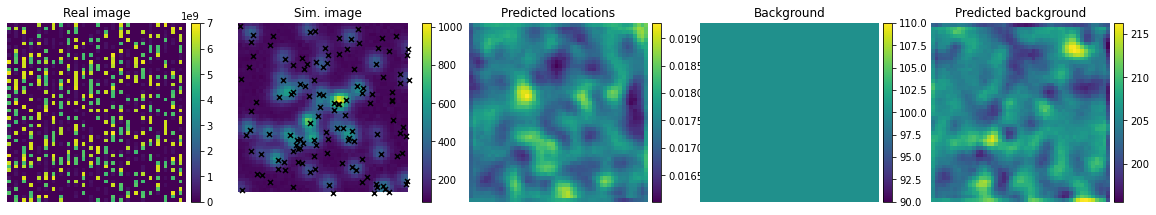

100
1015


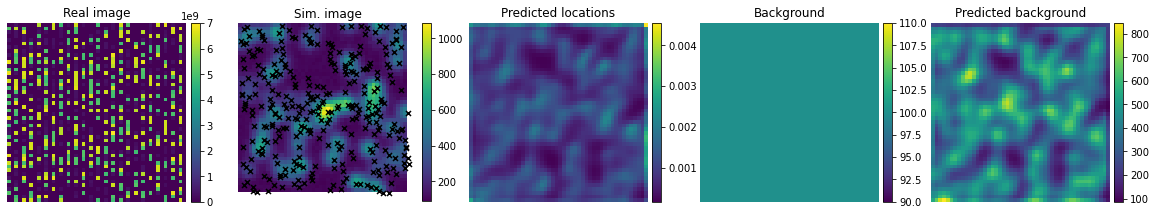

In [ ]:
train(cfg=cfg,
     model=model, 
     microscope=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict, 
     eval_dict=None)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted index.ipynb.
